# TP 4 : Approximation Functions

We want to extend the methods we have seen for discrete state spaces to 
to problems with arbitrarily large state spaces. In the case of a video game for example, the number of possible images is much larer than the number of atoms in the universe. We can't expect to find an optimal policy or the optimal value function. 
Our goal instead is to find a good approximate solution using limited computational resources. 

Because we will encounter states never seen before, we need to use data from previous encounter to perform generalization. We will see function approximation as a generalization method. You will probably be happy to find out that function approximation is a supervised learning problem, and as such we will be using methods you have seen in traditional Machine Learning courses.

In [ ]:
# Packages to install
# !pip install scikit-learn
#!pip install pyglet==1.5.27
# If you have errors with libGL, try in the terminal with your conda env activated :
# conda install -c conda-forge libstdcxx-ng

## Presentation of the Environment

In this project, you are asked to solve the classic Mountain Car (https://gym.openai.com/envs/MountainCar-v0/). Unlike previous environment, states are continuous so that you need to approximate the Q values Q(s, a). For more details about action and observation space, please refer to the OpenAI documentation here: https://github.com/openai/gym/wiki/MountainCar-v0

![](mountain_car.gif)


In [ ]:
from environment import Mountain
import numpy as np
env = Mountain()
state = env.observe()
done = False
while not done:
    action = np.random.choice([0, 1, 2])
    state, reward, done = env.step_from_state(state, action)

In [ ]:
import numpy as np
class RandomAgentQ:
    """ Dummy Agent 
    """

    def __init__(self):
        pass

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        pass

    def act(self, state):
        """Output optimal action of a given state
        Return: action in [0, 1, 2]
        """
        return np.random.choice([0, 1, 2])

    def update(self, state, action, reward, new_state, terminal):
        """Receive a reward for performing given action.

        This is where your agent can learn. 
        Input:
            state: current state
            action: action done in state
            reward: reward received after doing action in state
            new_state: next state
            terminal: boolean if new_state is a terminal state or not
        """
        pass


    def q(self, state, action):
        """Final Q function.
            Value (scalar): Q(state, action)
        """
        return np.random.uniform(0, 1)

Episode  1
Simulation step 0:
 ->       game: 1
 ->       observation: [-0.5851761  0.       ]
 ->            action: 2
 ->            reward: -1.0
 -> cumulative reward: -1.0

Simulation step 1:
 ->       game: 1
 ->       observation: [-0.5837169   0.00145921]
 ->            action: 2
 ->            reward: -1.0
 -> cumulative reward: -2.0

Simulation step 2:
 ->       game: 1
 ->       observation: [-0.5808093   0.00290765]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -3.0

Simulation step 3:
 ->       game: 1
 ->       observation: [-0.57847464  0.00233463]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -4.0

Simulation step 4:
 ->       game: 1
 ->       observation: [-0.5767303   0.00174434]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -5.0

Simulation step 5:
 ->       game: 1
 ->       observation: [-0.5755892   0.00114114]
 ->            action: 1
 ->            reward: -1.0
 -> cumulati

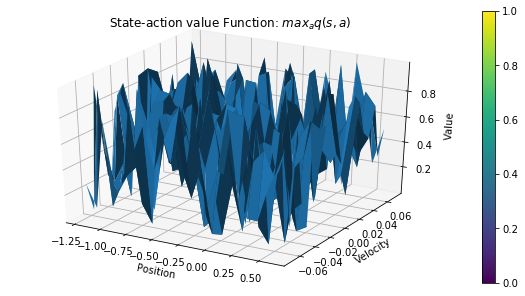

In [ ]:
### Example code ###

from runner import FARunner
from environment import Mountain

n_episodes = 1
max_iter=100

env_class = Mountain
agent_class = RandomAgentQ


# Differentiate Between value and q based algorithms
type_values = ["state_action_value","state_value"]


# Running a Single Agent on a single environment.

my_runner = FARunner(env_class(), agent_class(), type_values[0], verbose=True)
final_reward = my_runner.loop(n_episodes,max_iter)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline
import numpy as np

## Linear approximation of state Value $V(s)$ 

We first are going to consider an parametrized estimation of the value function $$v_\pi(s) \sim \hat{v}(s,\bold{\theta})$$ with parameters $\bold{\theta}$. You can think of the process of generalization in two different ways :
- We simplify the problem by computing similarity elements between states  -> feature learning
- We extend the behavior of the policy to multiple states -> Optimization on a parametrized function class 

### Monte-Carlo State Value Approximation

Q.1 Test the Linear Monte-Carlo State Value Approximation algorithm ( See Sutton Barto, 9.3 and 9.4) 

We are using randomly sampled features to represent the state space. ( see Barto - Sutton 9.5.2) $$ s \sim \bold{x}$$ with $\bold{x} = (x_1,...,x_n)$ is a decomposition on randomly sampled Fourier Coefficients.

In [ ]:
class MC_State_Value_Approximation:
    """ MC State-value Learning with Function Approximation
    """

    def __init__(self):
        """
        Init:
            gamma: discount factor
            preprocessing_states: preprocessing state features for better representation
            mdp: instance of environment, allowing to simulate action with self.mdp.step_from_state(current_state, action)
            theta: linear weight (function approximation)
        """
        self.gamma = 0.9
        n_components = 10 # You can change
        self.preprocessing_states = Pipeline([("scaler", StandardScaler()), ("feature_generation", RBFSampler(n_components=n_components))])
        self.preprocessing_states.fit(np.array([[np.random.uniform(-1.2, 0.6), np.random.uniform(-0.07, 0.07)] for _ in range(10000)]))
        self.mdp = Mountain()
        self.theta = np.zeros(n_components) # Linear weight

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        return self.preprocessing_states.transform([state])[0]

    def act(self, state):
        """Output optimal action of a given state
        Returns: action in [0, 1, 2]
        """

        Vs = np.array([self.v(self.mdp.step_from_state(state, action)[0]) for action in [0, 1, 2]])
        idx_best = np.argsort(-Vs)

        if np.random.uniform(0, 1) < 0.1:
            return np.random.choice(list(idx_best[1:]))
        else:
            return idx_best[0]

    def update(self, state, action, reward, new_state, terminal):
        """Receive a reward after performing given action.

        This is where your agent can learn. (Update theta.)
        Parameters:
            state: current state
            action: action done in state
            reward: reward received after doing action in state
            new_state: next state
            terminal: boolean if new_state is a terminal state or not
        """
        if terminal:
            self.theta = self.theta + 1e-3 * (reward - self.v(state)) * self.preprocessing(state)
        else:
            done = False
            s = new_state
            i = 1
            target = reward
            while (not done) and (i < 30):
                s, r, done = self.mdp.step_from_state(s, self.act(s))
                target += r * self.gamma**i
                i += 1

            self.theta = self.theta + 1e-3 * (target - self.v(state)) * self.preprocessing(state)

    def v(self, state):
        """Final V function.
        Return:
            Value (scalar): V(state)
        """
        return np.dot(self.preprocessing(state), self.theta)




Episode  1
Simulation step 0:
 ->       game: 1
 ->       observation: [-0.46680722  0.        ]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -1.0

Simulation step 1:
 ->       game: 1
 ->       observation: [-0.4682311  -0.00142388]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -2.0

Simulation step 2:
 ->       game: 1
 ->       observation: [-0.47106832 -0.00283723]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -3.0

Simulation step 3:
 ->       game: 1
 ->       observation: [-0.47529793 -0.00422958]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -4.0

Simulation step 4:
 ->       game: 1
 ->       observation: [-0.4808885  -0.00559057]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -5.0

Simulation step 5:
 ->       game: 1
 ->       observation: [-0.4877985  -0.00691002]
 ->            action: 0
 ->            reward: -1.0
 -> cumula

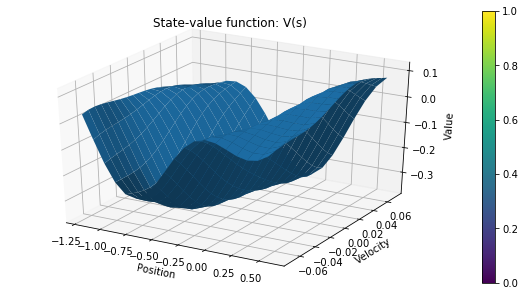

In [ ]:
### Example code ###

from runner import FARunner
from environment import Mountain

n_episodes = 1
max_iter=100

env_class = Mountain
agent_class = MC_State_Value_Approximation


# Differentiate Between value and q based algorithms
type_values = ["state_action_value","state_value"]


# Running a Single Agent on a single environment.

my_runner = FARunner(env_class(), agent_class(), type_values[1], verbose=True)
final_reward = my_runner.loop(n_episodes,max_iter)

Q.2 Implement the Linear Semi-Gradient TD(0) : ( See Sutton Barto, 9.3 and 9.4)

In [ ]:

class TD0_State_Value_Approximation:
    """ TD(0) State-value Learning with Function Approximation
    """

    def __init__(self):
        """
        Init:
            gamma: discount factor
            preprocessing_states: preprocessing state features for better representation
            mdp: instance of environment, allowing to simulate action with self.mdp.step_from_state(current_state, action)
            theta: linear weight (function approximation)
        """
        self.gamma = 0.9
        n_components = 10 # You can change
        self.preprocessing_states = Pipeline([("scaler", StandardScaler()), ("feature_generation", RBFSampler(n_components=n_components))])
        self.preprocessing_states.fit(np.array([[np.random.uniform(-1.2, 0.6), np.random.uniform(-0.07, 0.07)] for _ in range(10000)]))
        self.mdp = Mountain()
        self.theta = np.zeros(n_components) # Linear weight
        self.alpha = 0.1

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        return self.preprocessing_states.transform([state])[0]

    def act(self, state):
        """Output optimal action of a given state
        Return: action in [0, 1, 2]
        """
        # TO IMPLEMENT
        values = []
        for action in [0, 1, 2]:
            new_state, reward, _ = self.mdp.step_from_state(state, action)
            values.append(reward + self.gamma * self.v(new_state))
        return np.argmax(values)

    def update(self, state, action, reward, new_state, terminal):
        """Receive a reward after performing given action.

        This is where your agent can learn. (Update theta.)
        Input:
            state: current state
            action: action done in state
            reward: reward received after doing action in state
            new_state: next state
            terminal: boolean if new_state is a terminal state or not
        """
        # compute the TD error:
        delta = reward + self.gamma * self.v(new_state) - self.v(state)
        # update the linear weight theta:
        self.theta += self.alpha * delta * self.preprocessing(state)

    def v(self, state):
        """Final V function.
        Return:
            Value (scalar): V(state)
        """
        return self.theta.dot(self.preprocessing(state))

Episode  1
Simulation step 0:
 ->       game: 1
 ->       observation: [-0.54935265  0.        ]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -1.0

Simulation step 1:
 ->       game: 1
 ->       observation: [-0.5501597  -0.00080704]
 ->            action: 2
 ->            reward: -1.0
 -> cumulative reward: -2.0

Simulation step 2:
 ->       game: 1
 ->       observation: [-5.4976773e-01  3.9195782e-04]
 ->            action: 2
 ->            reward: -1.0
 -> cumulative reward: -3.0

Simulation step 3:
 ->       game: 1
 ->       observation: [-0.5481797   0.00158802]
 ->            action: 2
 ->            reward: -1.0
 -> cumulative reward: -4.0

Simulation step 4:
 ->       game: 1
 ->       observation: [-0.5454075   0.00277221]
 ->            action: 2
 ->            reward: -1.0
 -> cumulative reward: -5.0

Simulation step 5:
 ->       game: 1
 ->       observation: [-0.54147184  0.00393566]
 ->            action: 2
 ->            reward: -1.0
 -> 

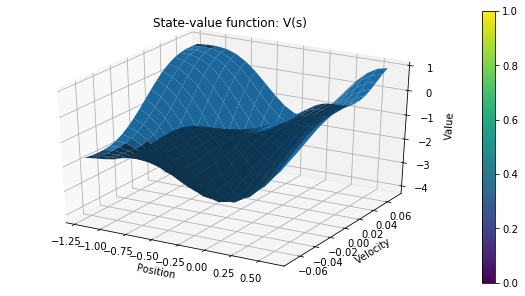

In [ ]:
### Example code ###

from runner import FARunner
from environment import Mountain

n_episodes = 1
max_iter=100

env_class = Mountain
agent_class = TD0_State_Value_Approximation


# Differentiate Between value and q based algorithms
type_values = ["state_action_value","state_value"]


# Running a Single Agent on a single environment.

my_runner = FARunner(env_class(), agent_class(), type_values[1], verbose=True)
final_reward = my_runner.loop(n_episodes,max_iter)

### n-step-TD State Value Approximation

Q.3 Implement the n-step-TD State Value Approximation

In [ ]:

class n_steps_TD_State_Value_Approximation:
    """ TD(lambda) State-value Learning with Function Approximation
    http://www.incompleteideas.net/book/7/node2.html
    """

    def __init__(self):
        """
        Init:
            gamma: discount factor
            preprocessing_states: preprocessing state features for better representation
            mdp: instance of environment, allowing to simulate action with self.mdp.step_from_state(current_state, action)
            theta: linear weight (function approximation)
            lambda_value: Monte-Carlo step
        """
        self.gamma = 0.9
        n_components = 10 # You can change
        self.preprocessing_states = Pipeline([("scaler", StandardScaler()), ("feature_generation", RBFSampler(n_components=n_components))])
        self.preprocessing_states.fit(np.array([[np.random.uniform(-1.2, 0.6), np.random.uniform(-0.07, 0.07)] for _ in range(10000)]))
        self.mdp = Mountain()
        self.theta = np.zeros(n_components) # Linear weight
        self.mc_steps = 5 # Monte Carlo steps
        self.alpha = 0.1

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        return self.preprocessing_states.transform([state])[0]

    def act(self, state):
        """Output optimal action of a given state
        Return: action in [0, 1, 2]
        """
        # Compute the state values for each action
        action_values = []
        for action in range(3):
            value = np.dot(self.theta, self.preprocessing(state))
            action_values.append(value)

        # Return the action with the highest state value
        return np.argmax(action_values)


    def update(self, state, action, reward, new_state, terminal):
        """Receive a reward after performing given action.

        This is where your agent can learn. (Update theta.)
        Input:
            state: current state
            action: action done in state
            reward: reward received after doing action in state
            new_state: next state
            terminal: boolean if new_state is a terminal state or not
        """
        # Compute the state-value prediction for the current state
        state_prediction = np.dot(self.theta, self.preprocessing(state))

        # If the new state is not terminal, compute the state-value prediction for the new state
        if not terminal:
            new_state_prediction = np.dot(self.theta, self.preprocessing(new_state))
        else:
            new_state_prediction = 0

        # Compute the TD error
        td_error = reward + self.gamma * new_state_prediction - state_prediction

        # Update the weights using the n-step TD update rule
        self.theta += self.alpha * td_error * self.preprocessing(state)


    def v(self, state):
        """Final V function.
        Return:
            Value (scalar): V(state)
        """
        # Preprocess the state
        state = self.preprocessing(state)
        # Return the dot product of the linear weight and the state features
        return np.dot(self.theta, state)

Episode  1
Simulation step 0:
 ->       game: 1
 ->       observation: [-0.5341789  0.       ]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -1.0

Simulation step 1:
 ->       game: 1
 ->       observation: [-0.53509957 -0.00092066]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -2.0

Simulation step 2:
 ->       game: 1
 ->       observation: [-0.53693396 -0.00183442]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -3.0

Simulation step 3:
 ->       game: 1
 ->       observation: [-0.5396684  -0.00273444]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -4.0

Simulation step 4:
 ->       game: 1
 ->       observation: [-0.5432824  -0.00361396]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -5.0

Simulation step 5:
 ->       game: 1
 ->       observation: [-0.5477488  -0.00446642]
 ->            action: 0
 ->            reward: -1.0
 -> cumulati

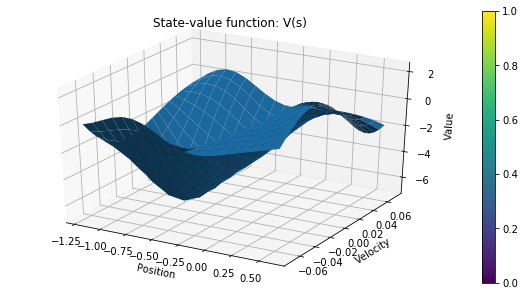

In [ ]:
### Example code ###

from runner import FARunner
from environment import Mountain

n_episodes = 1
max_iter=100

env_class = Mountain
agent_class = n_steps_TD_State_Value_Approximation

# Differentiate Between value and q based algorithms
type_values = ["state_action_value","state_value"]

# Running a Single Agent on a single environment.
my_runner = FARunner(env_class(), agent_class(), type_values[1], verbose=True)
final_reward = my_runner.loop(n_episodes,max_iter)

## Linear approximation of state-action Value Q(s, a)

We then  are going to consider an parametrized estimation of the value function $$q_\pi(s,a) \sim \hat{q}(s,a,\bold{\theta})$$ with parameters $\bold{\theta}$. 

Q.4 Implement the TD(0) State-Action Value Approximation

In [ ]:
class TD0_Q_Learning_Function_Approximation:
    """ Q-Learning with Function Approximation
    """

    def __init__(self):
        """
        Init:
            gamma: discount factor
            preprocessing_states: preprocessing state features for better representation
            mdp: instance of environment, allowing to simulate action with self.mdp.step_from_state(current_state, action)
            theta: linear weight (function approximation)
        """
        self.gamma = 0.9
        n_components = 10
        self.preprocessing_states = Pipeline([("scaler", StandardScaler()), ("feature_generation", RBFSampler(n_components=n_components))])
        self.preprocessing_states.fit(np.array([[np.random.uniform(-1.2, 0.6), np.random.uniform(-0.07, 0.07)] for _ in range(10000)]))
        self.mdp = Mountain()
        self.theta = np.zeros((3, n_components)) # 3 actions
        self.alpha = 0.1

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        return self.preprocessing_states.transform([state])[0]


    def act(self, state):
        state_features = self.preprocessing(state)

        # Compute action-value for each action
        action_values = []
        for action in range(3):
            action_values.append(np.dot(self.theta[action], state_features))

        # Return action with maximum action-value
        return np.argmax(action_values)
        

    def update(self, state, action, reward, new_state, terminal):
        state_features = self.preprocessing(state)
        new_state_features = self.preprocessing(new_state)

        # Compute TD error
        td_error = reward + (self.gamma * np.max(np.dot(self.theta, new_state_features))) - np.dot(self.theta[action], state_features)
        if terminal:
            td_error = reward - np.dot(self.theta[action], state_features)

        # Update weights for the current action
        self.theta[action] += self.alpha * td_error * state_features


    def q(self, state, action):
        # Preprocess the state
        state_features = self.preprocessing(state)
        # Return the dot product of the linear weight and the state features
        return np.dot(self.theta[action], state_features)


Episode  1
Simulation step 0:
 ->       game: 1
 ->       observation: [-0.44367445  0.        ]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -1.0

Simulation step 1:
 ->       game: 1
 ->       observation: [-0.44526815 -0.00159371]
 ->            action: 1
 ->            reward: -1.0
 -> cumulative reward: -2.0

Simulation step 2:
 ->       game: 1
 ->       observation: [-0.44744396 -0.00217579]
 ->            action: 2
 ->            reward: -1.0
 -> cumulative reward: -3.0

Simulation step 3:
 ->       game: 1
 ->       observation: [-0.44918597 -0.001742  ]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -4.0

Simulation step 4:
 ->       game: 1
 ->       observation: [-0.45248142 -0.00329547]
 ->            action: 1
 ->            reward: -1.0
 -> cumulative reward: -5.0

Simulation step 5:
 ->       game: 1
 ->       observation: [-0.45630625 -0.00382481]
 ->            action: 2
 ->            reward: -1.0
 -> cumula

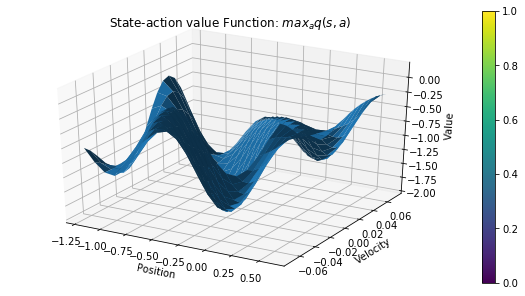

In [ ]:
### Example code ###

from runner import FARunner
from environment import Mountain

n_episodes = 1
max_iter=100

env_class = Mountain
agent_class = TD0_Q_Learning_Function_Approximation


# Differentiate Between value and q based algorithms
type_values = ["state_action_value","state_value"]


# Running a Single Agent on a single environment.

my_runner = FARunner(env_class(), agent_class(), type_values[0], verbose=True)
final_reward = my_runner.loop(n_episodes,max_iter)

## (BONUS ) Deep Q-network

The paper https://arxiv.org/pdf/1312.5602.pdf explore a method of training neural network using Experience Replay. 

You have to store the agent experience (observation,action,reward,next_state) in memory D and apply Q-Learning on samples drawn from D. 

BONUS : Implement the deep Q-network algorithm : https://arxiv.org/pdf/1312.5602.pdf

In [ ]:
# Import the necessary modules
import gym

# Create an instance of the CartPole environment
env = gym.make("MountainCar-v0")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random


class DQN(nn.Module):
    def __init__(self, state_shape, n_actions, hidden_layers, learning_rate):
        super(DQN, self).__init__()
        self.state_shape = int(state_shape)
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = 0.9
        self.hidden_layers = hidden_layers

        # Define the neural network
        self.model = self._build_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)


    def _build_model(self):
        # Define the input layer
        model = nn.Sequential(nn.Linear(self.state_shape, self.hidden_layers[0]))
        
        # Define the hidden layers
        for i, units in enumerate(self.hidden_layers[1:]):
            model.add_module(f'hidden_{i+1}', nn.Linear(self.hidden_layers[i], units))
            model.add_module(f'hidden_{i+1}_relu', nn.ReLU())
        
        # Define the output layer
        model.add_module('output', nn.Linear(self.hidden_layers[-1], self.n_actions))
        
        return model

    def predict(self, states):
        # Use the neural network to predict the action-values for a given state
        # Convert states to tensor
        states = torch.tensor(states, dtype=torch.float)
        # Use the neural network to predict the action-values for the given states
        q_values = self.model(states)
        return q_values

    def update(self, states, actions, rewards, next_states, dones):
        # Compute the target action-values using the Bellman equation
        with torch.no_grad():
            # Compute the predicted action-values
            q_values = self.predict(states)

            next_q_values = torch.max(self.predict(next_states), dim=1)[0]
            # print("next_q_values",next_q_values)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Update the predicted action-values using the computed target action-values
        for i, action in enumerate(actions):
            q_values[i][action] = target_q_values[i]

        # Reshape the q_values tensor to have the same shape as the target_q_values tensor
        q_values = torch.tensor(q_values.unsqueeze(1), requires_grad=True)
        target_q_values = torch.tensor(target_q_values, requires_grad=True)
        
        # Compute the loss
        loss = F.mse_loss(q_values, target_q_values[0])
       
        # Perform backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()


In [ ]:
import torch.nn as nn
import torch
from matplotlib import pyplot as plt


class Trainer:
    def __init__(self, n_epoch, batch_size, lr, epsilon_start, epsilon_end, epsilon_decay):
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.lr = lr
        self.n_epoch = n_epoch
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay

    def trainer(self, model, draw_image=True):
        # Initialize the DQN and the experience replay memory
        memory = []

        # Initialize the state and the epsilon value
        state = env.reset()
        
        losses_train = []
        # Loop over the maximum number of steps
        for step in range(self.n_epoch):
            # Choose an action using the DQN and the epsilon-greedy policy
            if random.uniform(0, 1) < self.epsilon:
                # Choose a random action
                action = env.action_space.sample()
            else:
                # Choose the action with the highest Q-value
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()

            # Execute the chosen action and observe the reward and the next state
            next_state, reward, done, _ = env.step(action)

            # Add the transition to the experience replay memory
            memory.append((state, action, reward, next_state, done))
            
            # # Sample a mini-batch of transitions from the experience replay memory
            # batch = random.sample(memory, batch_size)
            # Sample a mini-batch of transitions from the experience replay memory
            sample_size = min(self.batch_size, len(memory))
            batch = random.sample(memory, sample_size)
            # batch = np.random.choice(memory, size=sample_size, replace=False)

            # Update the DQN using the sampled transitions
            states, actions, rewards, next_states, dones = zip(*batch)
            dones = 0 if dones[0]==False else 1
            rewards = rewards[0]
            loss = model.update(states, actions, rewards, next_states, dones)
            print("loss", loss)

            # Decrease the epsilon value
            epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

            # Set the current state to the next state
            state = next_state
            
            # Check if the episode is finished
            if done:
                # Reset the environment and the state
                state = env.reset()
            losses_train.append(loss)    

        if draw_image:
            self.draw_image(losses_train)

    def draw_image(self, training_loss):
        plt.plot(training_loss, label="training loss")
        plt.legend()
        plt.show()

In [ ]:
# Define the DQN with two hidden layers
state_shape = env.observation_space.shape[0]
n_actions = env.action_space.n
hidden_layers = [64, 64]
learning_rate = 1e-3

dqn = DQN(state_shape, n_actions, hidden_layers, learning_rate)
# Set hyperparameters
batch_size = 32
gamma = 0.95
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
n_epoch = 1000

# Initialize the DQN and the experience replay memory
memory = []

# Initialize the state and the epsilon value
state = env.reset()
epsilon = epsilon_start

trainer = Trainer(n_epoch, batch_size, learning_rate, epsilon_start, epsilon_end, epsilon_decay)
trainer.trainer(dqn)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c4d4ca24-5f93-445d-849c-81431b0dd1b8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>